## Setup

In [34]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [36]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [37]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [38]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [39]:
%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",
                        total_units = "B25001_001",
                        asia_90_99="B05007_034"
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)


nyc_census_data


Simple feature collection with 6981 features and 5 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                       NAME    variable estimate
1  36081014700  Census Tract 147, Queens County, New York  population     2863
2  36081014700  Census Tract 147, Queens County, New York  asia_90_99       33
3  36081014700  Census Tract 147, Queens County, New York total_units     1570
4  36047058400   Census Tract 584, Kings County, New York  population     3655
5  36047058400   Census Tract 584, Kings County, New York  asia_90_99      193
6  36047058400   Census Tract 584, Kings County, New York total_units     1498
7  36061006900 Census Tract 69, New York County, New York  population     2450
8  36061006900 Census Tract 69, New York County, New York  asia_90_99       16
9  36061006900 Census Tract 69, New York Co

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [40]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  # pivot from wide to long
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )

nyc_census_data

Simple feature collection with 2327 features and 8 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 9
   GEOID NAME                   geometry population_estimate asia_90_99_estimate
   <chr> <chr>        <MULTIPOLYGON [°]>               <dbl>               <dbl>
 1 3608… Cens… (((-73.9137 40.76548, -7…                2863                  33
 2 3604… Cens… (((-73.96103 40.59616, -…                3655                 193
 3 3606… Cens… (((-74.02064 40.73039, -…                2450                  16
 4 3604… Cens… (((-73.93345 40.6257, -7…                2676                  25
 5 3604… Cens… (((-73.90735 40.63083, -…                3004                   6
 6 3604… Cens… (((-73.96279 40.72256, -…                1834                  26
 7 3600… Cens… (((-73.92012 40.83759, -…                4030                  31
 8 3608… Cens… (((-73.78

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [41]:
%%R 



# Extract borough name from NAME by splitting strings like 
# "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data %>% 
    mutate(
        borough = str_split(NAME, ",") %>% map_chr(2) %>% str_trim()
    )

### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


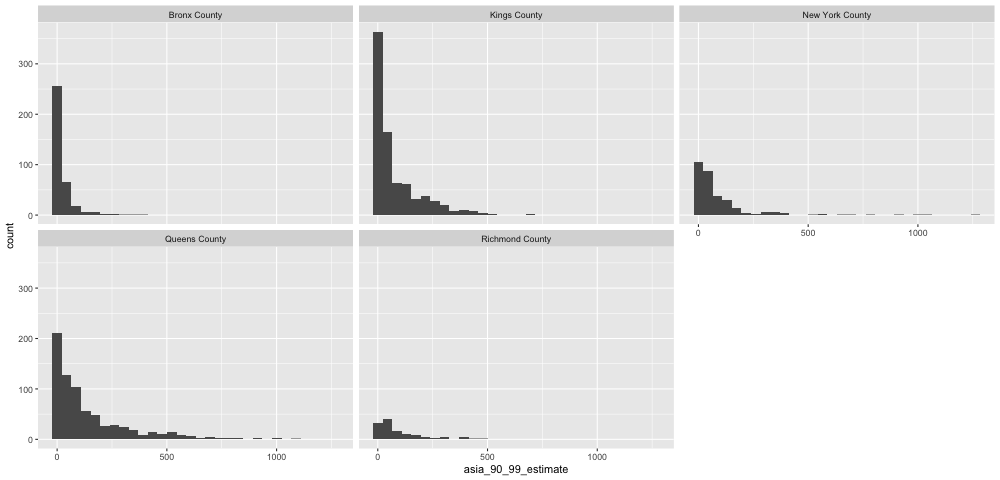

In [43]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=asia_90_99_estimate) +
    geom_histogram() + 
    facet_wrap(~borough) 
# your code here. refer to example notebooks for help


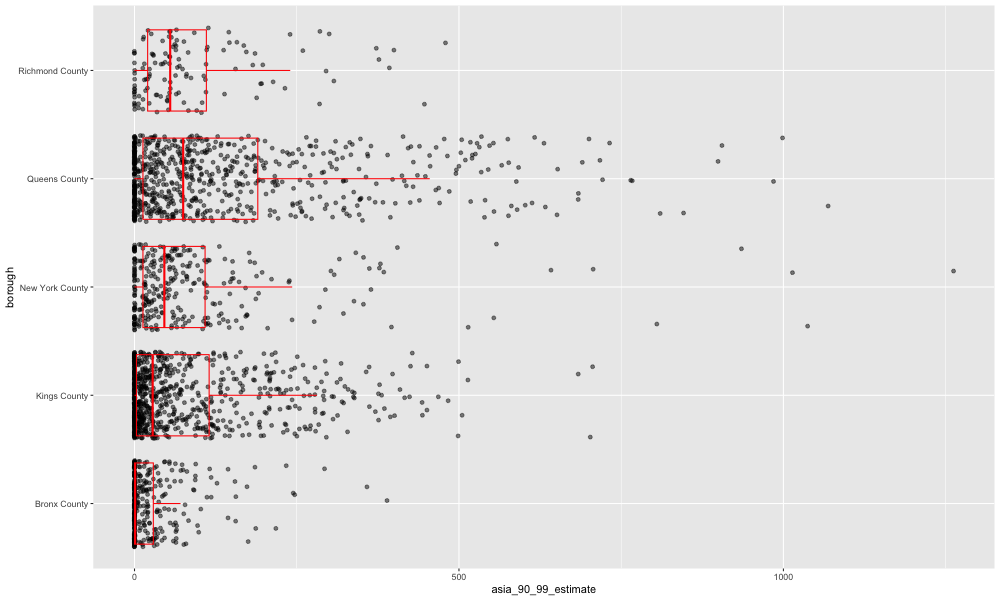

In [44]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=asia_90_99_estimate, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

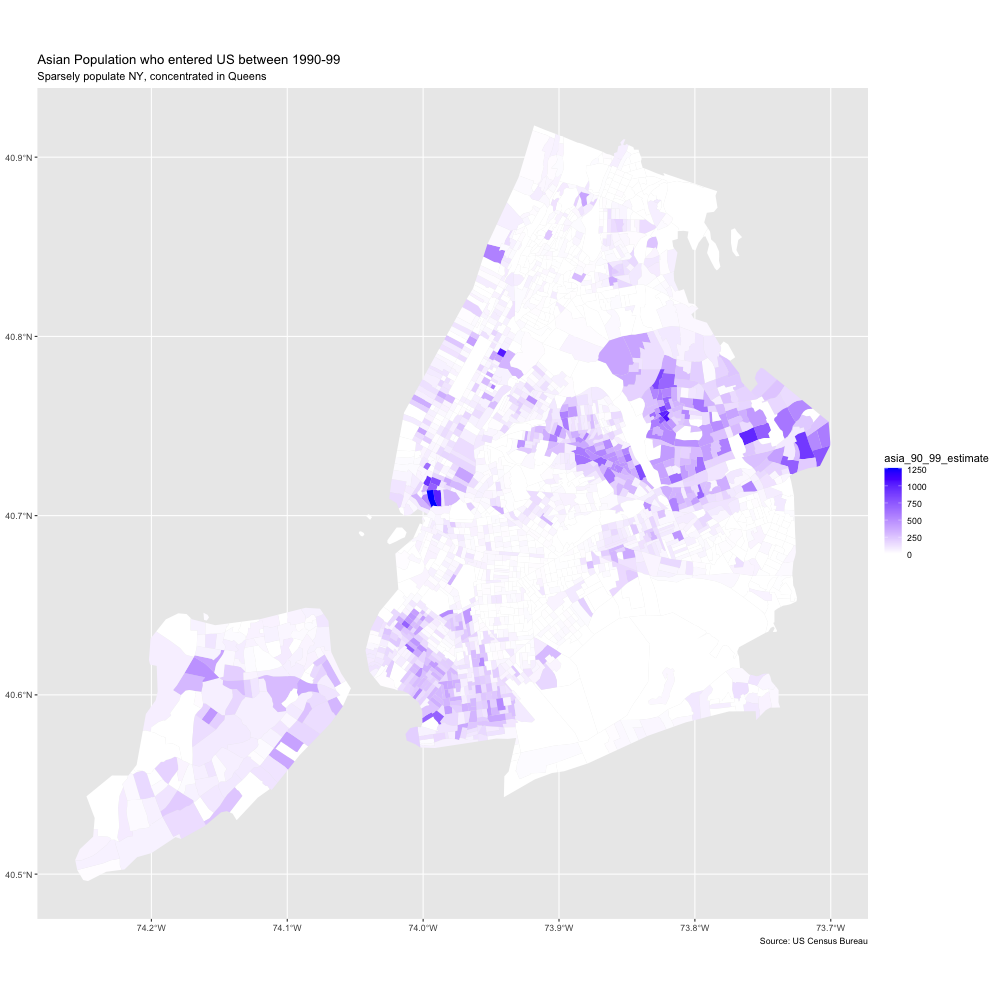

In [52]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = asia_90_99_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="blue") + 
  labs(
    title = "Asian Population who entered US between 1990-99",
    subtitle = "Sparsely populate NY, concentrated in Queens",
    caption = "Source: US Census Bureau"
  )


# your code here. refer to example notebooks for help
